In [4]:
import pandas as pd
import numpy as np
import helper
import missingno as msno
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import catboost as cb
from sklearn.decomposition import PCA
import seaborn as sns

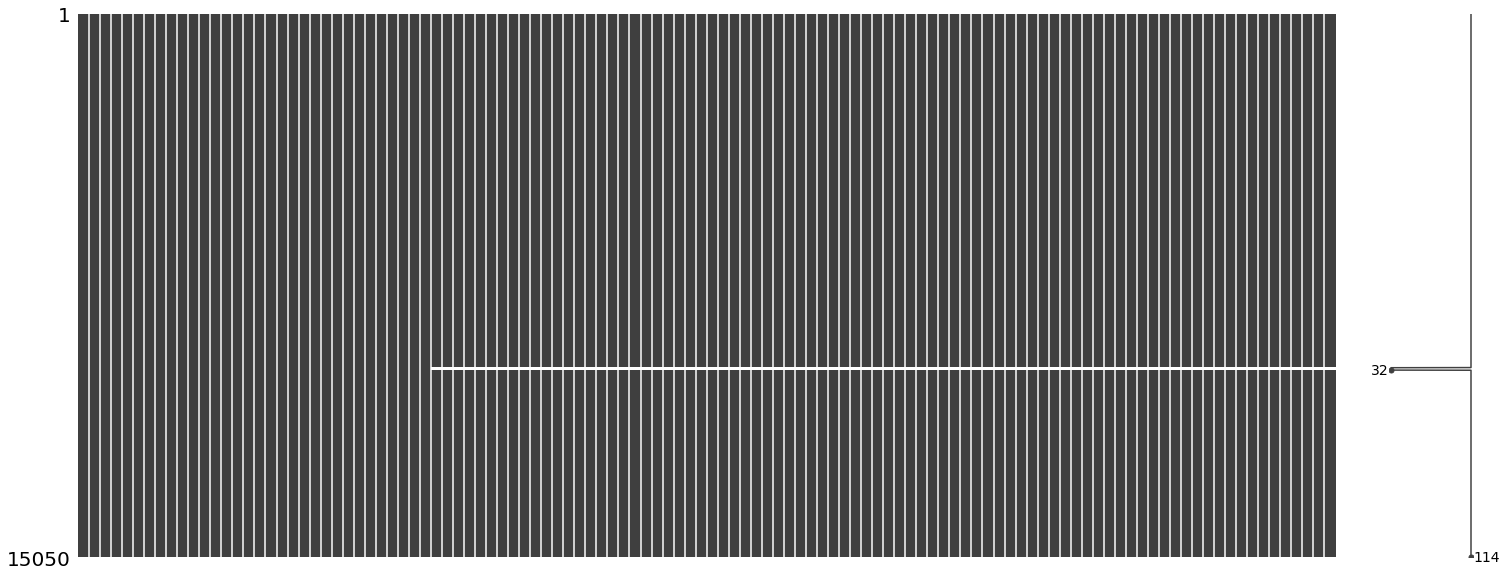

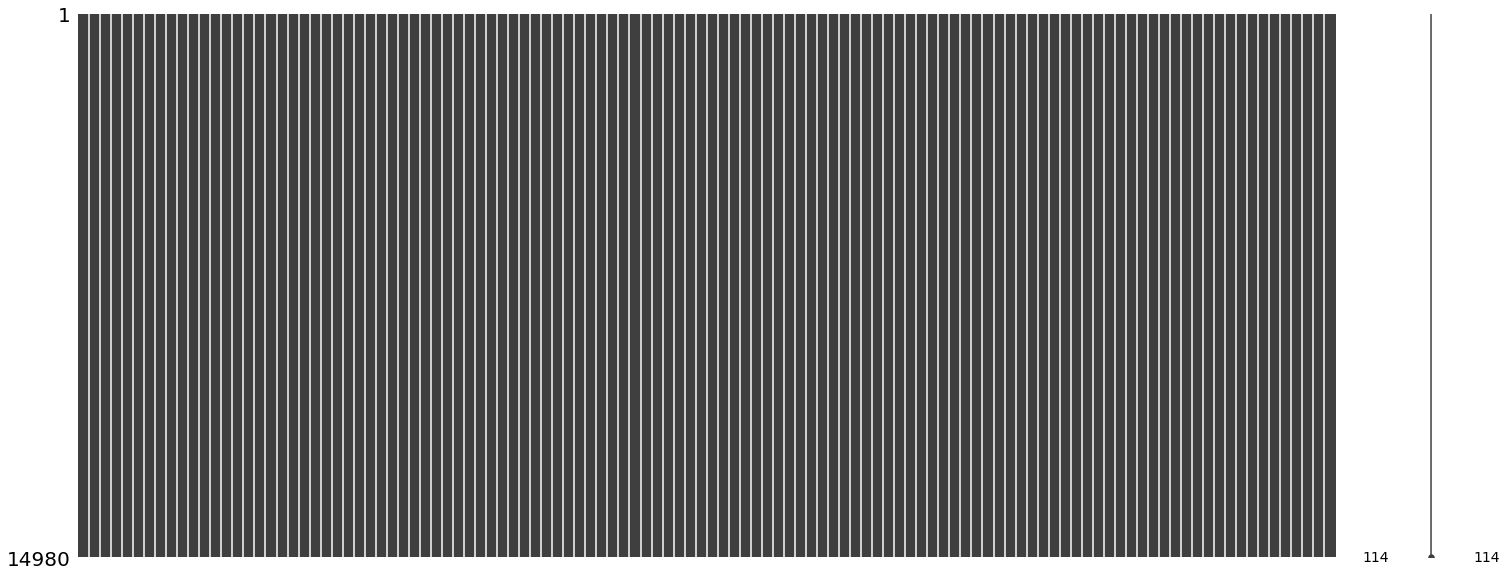

In [2]:
### Hayden's Code
# load data
texas_data = pd.read_csv('cleaned_data/merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('cleaned_data/merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# adding shift to zri
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', 
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
merged_df, texas_X_vals = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']).columns),
},
                                          return_cols = True
                                         )
# merge acs data
merged_df, acs_X_vals = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code','black_pop','white_pop',
                                     'hispanic_pop','high_school_diploma',
                                     'female_female_households','armed_forces']).columns),
    48:[
        'black_pop',
        'white_pop',
        'hispanic_pop',
        'high_school_diploma',
        'female_female_households',
        'armed_forces']                                               
},
                                          return_cols = True
                                         )
# visualize missing values. it should be that acs 2 does not have a single zipcode
# then removing that line and checking to see that there are no more missing values.
msno.matrix(merged_df)
plt.show()
merged_df = merged_df.dropna(axis=0)
msno.matrix(merged_df)
plt.show()

# creating list of variables to put into the model. initialy is all non index and target
X_vals = merged_df.drop(columns = ['Time','zip_code','zori_ssa']).columns.to_list()
# then remove variables that don't work for that given model.
bad_X_vals = [
    'sap_case_shiller_index_12_month_shift',
    'quintile_2_upper_limit_36_month_shift',
    'tx_is_abt_same_12_month_shift',
    'quintile_3_upper_limit_36_month_shift',
    'female_40_to_44_36_month_shift',
    'quintile_4_upper_limit_36_month_shift',
    'driving_alone_population_36_month_shift',
    'tx_is_better_12_month_shift',
    'children_36_month_shift',
    'female_45_to_49_36_month_shift',
    'average_household_size_owners_36_month_shift',
    'housing_units_10_to_19_units_36_month_shift',
    'housing_units_20_to_49_units_36_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'Single Family Building Permits TX_12_month_shift',
    'female_50_to_54_36_month_shift',
    'female_35_to_39_36_month_shift',
    'female_30_to_34_36_month_shift', 
    'median_household_income_36_month_shift',
    'female_25_to_29_36_month_shift',
    'single_women_36_month_shift',
    'sap_case_shiller_index_annual_pct_change_12_month_shift',
    'mintempC_annual_pct_change_12_month_shift',
    'tx_is_abt_same_annual_pct_change_12_month_shift',
    'housing_units_built_1990_to_1999_36_month_shift',
    'quintile_1_upper_limit_36_month_shift',
    'tx_is_worse_12_month_shift',
             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
# scaler = StandardScaler(with_mean=False)
X = train[X_vals]
# X = scaler.fit_transform(X)
y = train[y_val]
# test second
X_test = test[X_vals]
# X_test = scaler.transform(X_test)
y_test = test[y_val]

In [8]:
print(f'Train shape: {X.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (12412, 84)
Test shape: (2568, 84)


In [23]:

pca = PCA(n_components=83)
principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc 1', 'pc 2', 'pc 3', 'pc 4', 'pc 5'])
principalDf = pd.DataFrame(data = principalComponents)

In [24]:
principalDf

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,-1.605178e+07,-3358.564242,20408.052352,430.355487,-3874.390008,2029.441038,-2847.333398,3022.298517,734.421424,50.475883,...,0.009187,0.014240,-0.001844,0.014864,-0.008926,0.011259,-0.024395,-0.007473,0.005432,0.010039
1,-1.565862e+07,-3394.093275,20437.868311,423.576489,-3893.003126,2026.444890,-2842.166183,3015.580737,734.259250,47.684837,...,0.009181,0.015916,-0.000385,0.014453,-0.008883,0.011423,-0.026072,-0.007408,0.004684,0.009115
2,-1.631181e+07,-3335.073869,20388.301031,434.809194,-3862.050501,2031.165203,-2850.296917,3026.443864,734.384596,52.938725,...,0.009569,0.016232,0.001248,0.016252,-0.008717,0.012841,-0.025239,-0.007039,0.004476,0.007050
3,-1.616751e+07,-3348.114909,20399.238392,432.312462,-3868.870850,2029.990582,-2848.274022,3023.902283,734.283083,52.084033,...,0.013934,0.014152,-0.001464,0.013289,-0.009745,0.010493,-0.026548,-0.008103,0.005082,0.012226
4,-1.600193e+07,-3363.058717,20411.810543,429.487701,-3876.714701,2028.861002,-2846.323549,3021.242897,734.277971,50.535371,...,0.012639,0.016325,-0.001805,0.012714,-0.009495,0.011108,-0.026540,-0.007789,0.004533,0.015184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,9.866724e+06,-6675.791076,-17559.317014,-4715.224349,-3672.554441,-1001.185265,-316.106688,242.418982,-266.392334,-344.180225,...,0.089410,0.088982,-0.018992,0.017879,0.066519,-0.051428,0.008131,-0.037547,0.022582,0.004253
12408,1.063389e+07,-6745.129589,-17501.112240,-4728.445417,-3708.909474,-1006.829237,-306.383433,229.520751,-266.583453,-350.039925,...,0.088311,0.089079,-0.019673,0.018668,0.067277,-0.052261,0.007860,-0.037683,0.023053,0.000791
12409,1.739373e+07,-7355.654241,-16987.835741,-4844.164584,-4029.470177,-1052.771056,-227.126746,120.505050,-266.373294,-411.920936,...,0.087986,0.089861,-0.020965,0.020581,0.070272,-0.050183,0.008872,-0.037427,0.022857,-0.002038
12410,1.308773e+07,-6966.824052,-17314.846788,-4770.564964,-3825.256632,-1023.993384,-276.771431,189.314726,-266.736199,-371.110590,...,0.090482,0.090015,-0.020408,0.021367,0.068546,-0.052667,0.007377,-0.039420,0.023897,0.004745


In [25]:
principalComponents

array([[-1.60517772e+07, -3.35856424e+03,  2.04080524e+04, ...,
        -7.47325138e-03,  5.43193406e-03,  1.00393229e-02],
       [-1.56586199e+07, -3.39409327e+03,  2.04378683e+04, ...,
        -7.40806247e-03,  4.68408871e-03,  9.11463372e-03],
       [-1.63118090e+07, -3.33507387e+03,  2.03883010e+04, ...,
        -7.03905622e-03,  4.47550629e-03,  7.05006545e-03],
       ...,
       [ 1.73937314e+07, -7.35565424e+03, -1.69878357e+04, ...,
        -3.74268988e-02,  2.28573384e-02, -2.03842290e-03],
       [ 1.30877321e+07, -6.96682405e+03, -1.73148468e+04, ...,
        -3.94198076e-02,  2.38971816e-02,  4.74480704e-03],
       [ 1.18544240e+07, -6.85544615e+03, -1.74084791e+04, ...,
        -3.85587774e-02,  2.34656542e-02,  2.43313388e-03]])

In [26]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100.])

In [33]:
n_components = 10

pca_train = PCA(n_components)
train_reduced = pca_train.fit_transform(X)
pca_test = PCA(n_components)
test_reduced = pca_test.fit_transform(X_test)


In [39]:
df = pd.DataFrame({'PCA':pca_train.components_[1], 'Variable Names':list(X.columns)})
df = df.sort_values('PCA', ascending=False)
df

,PCA,Variable Names
80,0.962195,hispanic_pop_48_month_shift
81,0.156130,high_school_diploma_48_month_shift
31,0.134380,units_paying_cash_rent_36_month_shift
78,0.112360,black_pop_48_month_shift
29,0.084704,housing_units_built_1980_to_1989_36_month_shift
...,...,...
36,-0.000118,housing_units_single_family_attached_owned_36_...
27,-0.000647,women_with_doctoral_degree_36_month_shift
37,-0.002168,housing_units_over_50_units_36_month_shift
0,-0.008113,zori_ssa_12_month_shift


In [57]:
df2 = pd.DataFrame({'PCA':pca_train.components_[0], 'Variable Names':list(X.columns)})

In [54]:
#Sorting the values of the first principal component by how large each one is

for i in range(n_components):
    name = f'PCA_{i}'
    df = pd.DataFrame({f'PCA_{i}':pca_train.components_[i], f'Variable Names_{i}':list(X.columns)})
    df = df.sort_values(name, ascending=False)
    df2 = pd.concat([df2, df], axis=1)

In [62]:
#Sorting the values of the first principal component by how large each one is
n_components=10

for i in range(n_components):
    name = f'PCA_{i}'
    pca_train = PCA(n_components)
    train_reduced = pca_train.fit_transform(X)
    pca_test = PCA(n_components)
    test_reduced = pca_test.fit_transform(X_test)    
    print(f'---------------------PCA_{i}------------------\n')
    df = pd.DataFrame({f'PCA_{i}':pca_train.components_[i], f'Variable Names':list(X.columns)})
    df = df.sort_values(name, ascending=False)
    print(df.head(20))
#     df2 = pd.concat([df2, df], axis=1)

---------------------PCA_0------------------

           PCA_0                                     Variable Names
6   1.000000e+00                     total_sales_tax_12_month_shift
80  7.658799e-05                        hispanic_pop_48_month_shift
31  4.461811e-05              units_paying_cash_rent_36_month_shift
26  2.638036e-05    housing_units_built_1970_to_1979_36_month_shift
78  2.098338e-05                           black_pop_48_month_shift
37  2.019930e-05         housing_units_over_50_units_36_month_shift
30  1.031253e-05    housing_units_built_1930_to_1939_36_month_shift
32  1.022272e-05  housing_units_single_family_attached_36_month_...
29  8.030030e-06    housing_units_built_1980_to_1989_36_month_shift
36  7.905295e-06  housing_units_single_family_attached_owned_36_...
38  7.063067e-06    housing_units_built_1960_to_1969_36_month_shift
34  5.458932e-06           men_with_bachelors_degree_36_month_shift
21  5.367428e-06    housing_units_built_1940_to_1949_36_month_shift
24

---------------------PCA_6------------------

           PCA_6                                     Variable Names
26  5.520979e-01    housing_units_built_1970_to_1979_36_month_shift
38  4.122579e-01    housing_units_built_1960_to_1969_36_month_shift
81  3.615196e-01                 high_school_diploma_48_month_shift
24  3.006816e-01    housing_units_built_1950_to_1959_36_month_shift
79  4.849349e-02                           white_pop_48_month_shift
22  3.909043e-02                     female_75_to_79_36_month_shift
21  2.915072e-02    housing_units_built_1940_to_1949_36_month_shift
2   2.079182e-03                             zori_ssa_6_diff_lag_12
1   3.472003e-04                             zori_ssa_1_diff_lag_12
82  5.586976e-05            female_female_households_48_month_shift
10  1.891841e-05                   taxpayer_is_ratio_12_month_shift
6   1.172371e-05                     total_sales_tax_12_month_shift
55  1.049734e-05         female_21_annual_pct_change_36_month_shift
18

In [47]:
df2

,PCA,Variable Names,PCA,Variable Names,PCA,Variable Names,PCA,Variable Names,PCA,Variable Names,...,PCA,Variable Names,PCA,Variable Names,PCA,Variable Names,PCA,Variable Names,PCA,Variable Names
0,-1.048769e-06,zori_ssa_12_month_shift,-1.048769e-06,zori_ssa_12_month_shift,-8.112535e-03,zori_ssa_12_month_shift,1.428043e-03,zori_ssa_12_month_shift,-4.940602e-03,zori_ssa_12_month_shift,...,2.492822e-02,zori_ssa_12_month_shift,-0.037986,zori_ssa_12_month_shift,0.009157,zori_ssa_12_month_shift,0.021107,zori_ssa_12_month_shift,-0.018152,zori_ssa_12_month_shift
1,-3.864599e-08,zori_ssa_1_diff_lag_12,-3.864599e-08,zori_ssa_1_diff_lag_12,-3.340180e-06,zori_ssa_1_diff_lag_12,-3.787312e-05,zori_ssa_1_diff_lag_12,3.514572e-05,zori_ssa_1_diff_lag_12,...,8.868618e-05,zori_ssa_1_diff_lag_12,0.000347,zori_ssa_1_diff_lag_12,-0.000301,zori_ssa_1_diff_lag_12,0.000187,zori_ssa_1_diff_lag_12,0.000151,zori_ssa_1_diff_lag_12
2,-2.232330e-07,zori_ssa_6_diff_lag_12,-2.232330e-07,zori_ssa_6_diff_lag_12,-1.586044e-05,zori_ssa_6_diff_lag_12,-2.285933e-04,zori_ssa_6_diff_lag_12,1.737748e-04,zori_ssa_6_diff_lag_12,...,5.657568e-04,zori_ssa_6_diff_lag_12,0.002079,zori_ssa_6_diff_lag_12,-0.001783,zori_ssa_6_diff_lag_12,0.001086,zori_ssa_6_diff_lag_12,0.001008,zori_ssa_6_diff_lag_12
3,-2.882676e-10,zori_ssa_12_diff_lag_12_per,-2.882676e-10,zori_ssa_12_diff_lag_12_per,1.901876e-07,zori_ssa_12_diff_lag_12_per,-4.015465e-07,zori_ssa_12_diff_lag_12_per,3.813346e-07,zori_ssa_12_diff_lag_12_per,...,6.773315e-07,zori_ssa_12_diff_lag_12_per,0.000004,zori_ssa_12_diff_lag_12_per,-0.000003,zori_ssa_12_diff_lag_12_per,0.000001,zori_ssa_12_diff_lag_12_per,0.000003,zori_ssa_12_diff_lag_12_per
4,3.308974e-08,mintempC_12_month_shift,3.308974e-08,mintempC_12_month_shift,2.080174e-06,mintempC_12_month_shift,1.127720e-05,mintempC_12_month_shift,6.636231e-06,mintempC_12_month_shift,...,-1.894059e-06,mintempC_12_month_shift,-0.000005,mintempC_12_month_shift,0.000047,mintempC_12_month_shift,-0.000117,mintempC_12_month_shift,0.000112,mintempC_12_month_shift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,-8.498529e-05,white_pop_48_month_shift,-8.498529e-05,white_pop_48_month_shift,-6.589794e-02,white_pop_48_month_shift,9.793247e-01,white_pop_48_month_shift,-1.807744e-02,white_pop_48_month_shift,...,6.417712e-02,white_pop_48_month_shift,0.048493,white_pop_48_month_shift,-0.021694,white_pop_48_month_shift,-0.036927,white_pop_48_month_shift,0.009198,white_pop_48_month_shift
80,7.658799e-05,hispanic_pop_48_month_shift,7.658799e-05,hispanic_pop_48_month_shift,9.621951e-01,hispanic_pop_48_month_shift,3.933733e-02,hispanic_pop_48_month_shift,-1.785742e-01,hispanic_pop_48_month_shift,...,2.104892e-02,hispanic_pop_48_month_shift,-0.072095,hispanic_pop_48_month_shift,0.078068,hispanic_pop_48_month_shift,0.007362,hispanic_pop_48_month_shift,0.007678,hispanic_pop_48_month_shift
81,-1.491003e-06,high_school_diploma_48_month_shift,-1.491003e-06,high_school_diploma_48_month_shift,1.561301e-01,high_school_diploma_48_month_shift,7.602261e-02,high_school_diploma_48_month_shift,1.674283e-01,high_school_diploma_48_month_shift,...,-4.362363e-02,high_school_diploma_48_month_shift,0.361520,high_school_diploma_48_month_shift,-0.417432,high_school_diploma_48_month_shift,-0.250572,high_school_diploma_48_month_shift,-0.123936,high_school_diploma_48_month_shift
82,1.472150e-07,female_female_households_48_month_shift,1.472150e-07,female_female_households_48_month_shift,7.921947e-04,female_female_households_48_month_shift,9.948384e-04,female_female_households_48_month_shift,-9.026958e-06,female_female_households_48_month_shift,...,1.517340e-03,female_female_households_48_month_shift,0.000056,female_female_households_48_month_shift,-0.003188,female_female_households_48_month_shift,0.001867,female_female_households_48_month_shift,0.001027,female_female_households_48_month_shift


In [ ]:


#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
#print(df2['Variable Names'][0:11])

df.head()

In [ ]:
n_components = 10

pca = PCA(n_components)
train_reduced = pca.fit_transform(X)
test_reduced = pca.fit_transform(X_test)

#Sorting the values of the first principal component by how large each one is
df = pd.DataFrame({'PCA':pca_train.components_[0], 'Variable Names':list(X_train.columns)})
df = df.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
#print(df2['Variable Names'][0:11])

df.head()


for i in range(X.shape[1]):
    train_dataset = cb.Pool(X, y)
    test_dataset = cb.Pool(X_test, y_test)
    
    model = cb.CatBoostRegressor(iterations = 300, 
       learning_rate = 0.5, 
       depth = 7, 
       l2_leaf_reg = 0.5,
       loss_function='RMSE',
       verbose=False)

    model.fit(train_dataset)
    feat_names = X_test.columns.to_list()
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print("Testing performance")
    print(f'train: R2: {model.score(X, y)}')
    print(f'test: R2: {model.score(X_test, y_test)}')
    print(f'test: RMSE: {rmse}, R2: {r2}')

In [11]:
    train_dataset = cb.Pool(X, y)
    test_dataset = cb.Pool(X_test, y_test)

    model = cb.CatBoostRegressor(iterations = 300, 
       learning_rate = 0.5, 
       depth = 7, 
       l2_leaf_reg = 0.5,
       loss_function='RMSE',
       verbose=False)

    model.fit(train_dataset)
    feat_names = X_test.columns.to_list()
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print("Testing performance")
    print(f'train: R2: {model.score(X, y)}')
    print(f'test: R2: {model.score(X_test, y_test)}')
    print(f'test: RMSE: {rmse}, R2: {r2}')
#     print(f'RMSE: {rmse}, R2: {r2}, Worst Feature: {X_test.columns[model.feature_importances_.argsort()[0]]}')
#     cb_feature_df.loc[len(cb_feature_df.index)] = [X_test.shape[1], bottom_feature, rmse, r2]
    
#     bottom_feature = X_test.columns[model.feature_importances_.argsort()[0]]
#     X_test = X_test.drop(bottom_feature, axis=1)
#     X = X.drop(bottom_feature, axis=1)
#     print(f'dropping {bottom_feature}, new shape: {X_test.shape}')

Testing performance
train: RMSE: 0.9998693211621897
test: RMSE: 0.926212325575082
test: RMSE: 68.85526227246501, R2: 0.926212325575082
